# Transformers by Experiment




In [3]:
# !pip install transformers accelerate sentencepiece datasets seaborn --quiet

In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [102]:
model_id = 'gpt2'
tok = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True).to(device)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [103]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

## Talk to the model

In [26]:
def complete(prompt, max_new=40, top_k=20):
    inputs = tok(prompt, return_tensors='pt').to(device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_length=inputs['input_ids'].shape[1] + max_new,
            do_sample=True,
            top_k=top_k,
            temperature=0.9,
        )
    print(tok.decode(out[0], skip_special_tokens=True))

In [27]:
complete('Students at the university of Michigan are')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Students at the university of Michigan are the world's most popular undergraduate students in college. And they're also the most popular undergraduate students in the world. But they're also the most popular undergraduate students. As I've seen with some of


In [37]:
complete('Two times two equals')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Two times two equals one, and then the third comes, and so on. The first two times are just as important, but the third is far more important, as it shows us how we use the different ways of


In [22]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# GPT-2 Architecture Overview

The printed model summary shows the full structure of GPT-2 (small). It has three major components:



### Embeddings
- `wte`: token embedding matrix (vocab size 50,257 → 768-dim vectors)
- `wpe`: positional embedding matrix (positions 0–1023 → 768-dim vectors)

Every input token is converted to:

`embedding = wte[token_id] + wpe[position]`

In [21]:
import matplotlib
model.transformer.wpe.weight.detach().cpu()[0].shape

torch.Size([768])

### Transformer Blocks (12 total)
Each block performs two main operations:

#### Self-Attention
- `c_attn`: projects tokens to Q, K, V (all in one linear layer)
- `c_proj`: projects attention output back to 768-dim
- multi-head attention is created by slicing these projections

#### Feed-Forward Network (MLP)
- `c_fc`: expands 768 → 3072
- GELU nonlinearity
- `c_proj`: projects 3072 → 768

Both sublayers have:
- a LayerNorm before them (`ln_1`, `ln_2`)
- residual connections around them

Stacking 12 of these blocks gives the model its depth.


### 3. **Output Layer**
- `lm_head`: a linear map from hidden size (768) back to vocab size (50,257)
- tied weights with the embedding matrix (`wte`), meaning it reuses the same learned token vectors for output scoring


## Notes
- The model is entirely a stack of identical blocks.
- Each block only has  real operations: self-attention and a feed-forward network.
- Embeddings and the output head tie the model to the vocabulary.
- There is no recurrence and no convolution—just repeated attention and MLP layers.

## The positional embeddings


In [42]:
pos_embed = model.transformer.wpe.weight.detach().cpu().numpy()
pos_embed.shape

(1024, 768)

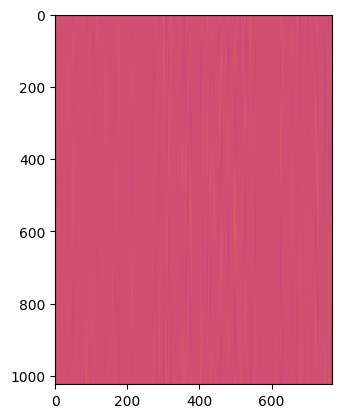

In [41]:
import matplotlib.pyplot as plt
plt.imshow(pos_embed, cmap="plasma")

## Token embeddings

In [49]:
s = "STATS 507 is highly cromulent."
tok.tokenize(s)

['ST', 'ATS', 'Ġ50', '7', 'Ġis', 'Ġhighly', 'Ġc', 'rom', 'ulent', '.']

In [50]:
len(tok)

50257

In [51]:
[v for v in tok.get_vocab() if "cat" in v][:20]

['Location',
 'ocated',
 'Application',
 'Ġrelocate',
 'Ġdedicated',
 'Ġvacations',
 'Ġcatalyst',
 'Ġrevocation',
 'Ġduplication',
 'Ġcat',
 'Ġcomplication',
 'ication',
 'Ġramifications',
 'Ġindicated',
 'Ġvacated',
 'Ġindicates',
 'Ġeducate',
 'Ġapplication',
 'Ġcomplicate',
 'catch']

In [54]:
tok.tokenize("unbelievable")


['un', 'bel', 'iev', 'able']

In [53]:
tok.tokenize("electroencephalogram")

['elect', 'ro', 'ence', 'ph', 'alog', 'ram']

In [56]:
tok.tokenize("cat")

['cat']

In [ ]:
tok.tokenize(" cat")

In [57]:
tok.tokenize("  cat")

['Ġ', 'Ġcat']

In [52]:
tok_emb = model.transformer.wte.weight.detach().cpu() 
tok_emb.shape

torch.Size([50257, 768])

In [53]:
import torch

def vec(word):
    """Return embedding vector for a word (handling GPT2 space issue)."""
    tid = tok.encode(" " + word)[0]  # GPT-2 uses "Ġword" convention
    return tok_emb[tid]

## Cosine similarity

Cosine similarity will tend to be higher for words that are related.

In [59]:
def cos(a, b):
    return torch.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [60]:
cos(vec("cat"), vec("dog"))

0.5497899055480957

In [61]:
cos(vec("cat"), vec("lawnmower"))

0.2847311198711395

In [63]:
cos(vec("river"), vec("stream"))

0.4608811140060425

In [64]:
cos(vec("carpet"), vec("pizza"))

0.3290719985961914

## Nearest neighbors in embedding space

In [66]:
def nearest_neighbors(word, k=10):
    v = vec(word)
    sims = torch.cosine_similarity(tok_emb, v.unsqueeze(0), dim=1)
    topk = torch.topk(sims, k+1).indices.tolist()  # +1 to skip the word itself
    decoded = [tok.decode([i]) for i in topk[1:]]
    return decoded

nearest_neighbors("prince", k=10)

[' princes',
 ' Prince',
 'Prince',
 ' princess',
 ' king',
 ' royal',
 ' emperor',
 ' kingdom',
 ' knight',
 ' lord']

## Analogies
The [word2vec paper](https://arxiv.org/abs/1301.3781) famously showed that, in the embedding space,

    king - man + woman ~= queen

In [67]:
def analogy(a, b, c, k=5):
    v = vec(a) - vec(b) + vec(c)
    sims = torch.cosine_similarity(tok_emb, v.unsqueeze(0), dim=1)
    top = torch.topk(sims, k).indices.tolist()
    return [tok.decode([i]) for i in top]

analogy("king", "man", "woman")

[' king', ' queen', ' princess', ' Queen', ' kings']

In [69]:
analogy("dog", "adult", "child")

[' dog', ' child', ' dogs', ' Dog', ' puppy']

In [71]:
analogy("carrots", "orange", "blue")

[' carrots', ' carrot', ' blue', ' broccoli', ' cabbage']

## Pluralization
Similarly, the "direction" from a word to its plural is roughly consistent:

In [78]:
pairs = [
    ("cat", "cats"),
    ("dog", "dogs"),
    ("car", "cars"),
    ("tree", "trees"),
]

dirs = [vec(p2) - vec(p1) for p1, p2 in pairs]
dirs = torch.stack(dirs)

plural = dirs.mean(dim=0)   # show first 10 dims of average plural direction

In [79]:
for i, (p1, p2) in enumerate(pairs):
    print(p1, "→", p2, cos(dirs[i], plural))

cat → cats 0.7916023135185242
dog → dogs 0.8208228349685669
car → cars 0.7899153828620911
tree → trees 0.7111148834228516


Other relations can encode similarly:

In [84]:
gender_dir = vec("woman") - vec("man")
gender_dir /= gender_dir.norm()

In [82]:
words = ["king","queen","man","woman","doctor","nurse","teacher","mother","father"]

for w in words:
    proj = torch.dot(vec(w), gender_dir).item()
    print(f"{w:10s} {proj: .3f}")

king       -0.229
queen       1.022
man        -1.140
woman       1.502
doctor      0.395
nurse       1.010
teacher     0.540
mother      0.780
father     -0.108


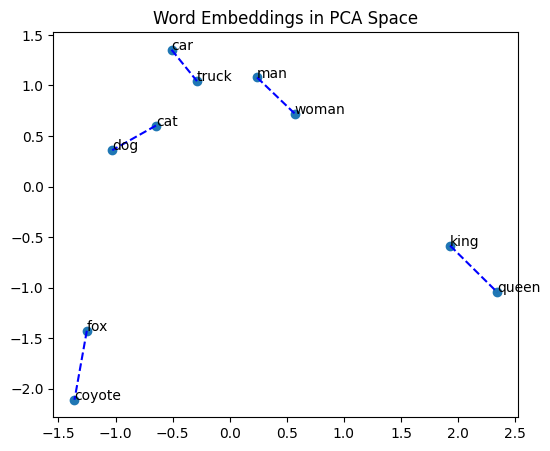

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools as it

words = ["cat","dog","car","truck","king","queen","man","woman","fox","coyote"]
X = torch.stack([vec(w) for w in words]).numpy()

p = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6,5))
plt.scatter(p[:,0], p[:,1])

for (x,y), w in zip(p, words):
    plt.text(x, y, w)

for (x1, y1), (x2, y2) in zip(p[::2], p[1::2]):
    plt.plot([x1, x2], [y1, y2], color="blue", linestyle="--")


plt.title("Word Embeddings in PCA Space")
plt.show()

## Understanding attention

In [104]:
def run(prompt):
    x = tok(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        out = model(**x)
    return x, out

In [105]:
out

CausalLMOutputWithCrossAttentions(loss=None, logits=tensor([[[ -36.2874,  -35.0114,  -38.0793,  ...,  -40.5163,  -41.3760,
           -34.9193],
         [ -71.8221,  -72.3168,  -74.6483,  ...,  -80.4650,  -74.6845,
           -74.2300],
         [-107.8303, -108.8460, -113.2836,  ..., -114.0244, -107.7450,
          -109.1604],
         ...,
         [-140.6220, -143.0160, -152.1795,  ..., -154.5174, -150.8332,
          -145.2452],
         [-103.9052, -105.7578, -112.0849,  ..., -120.2923, -116.2120,
          -107.9471],
         [-129.5772, -127.5908, -130.2931,  ..., -140.6855, -140.2777,
          -122.3181]]], device='cuda:0'), past_key_values=DynamicCache(layers=[DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer]), hidden_states=None, attentions=None, cross_attentions=None)

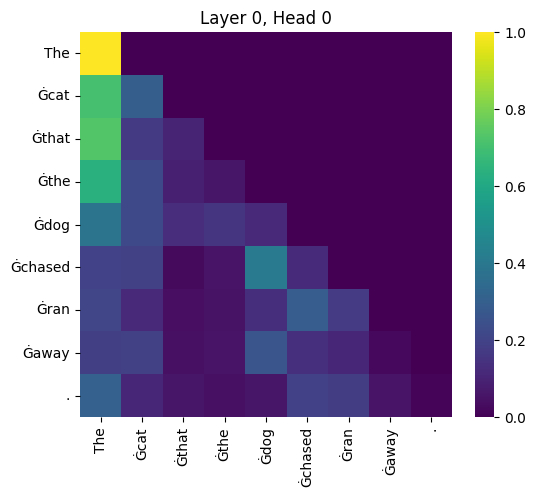

In [106]:
prompt = "The cat that the dog chased ran away."
x, out = run(prompt)

layer = 0
head = 0

A = out.attentions[layer][0, head].detach().cpu().numpy()
tokens = tok.convert_ids_to_tokens(x["input_ids"][0])

plt.figure(figsize=(6,5))
sns.heatmap(A, xticklabels=tokens, yticklabels=tokens,
            cmap="viridis")
plt.title(f"Layer {layer}, Head {head}")
plt.show()

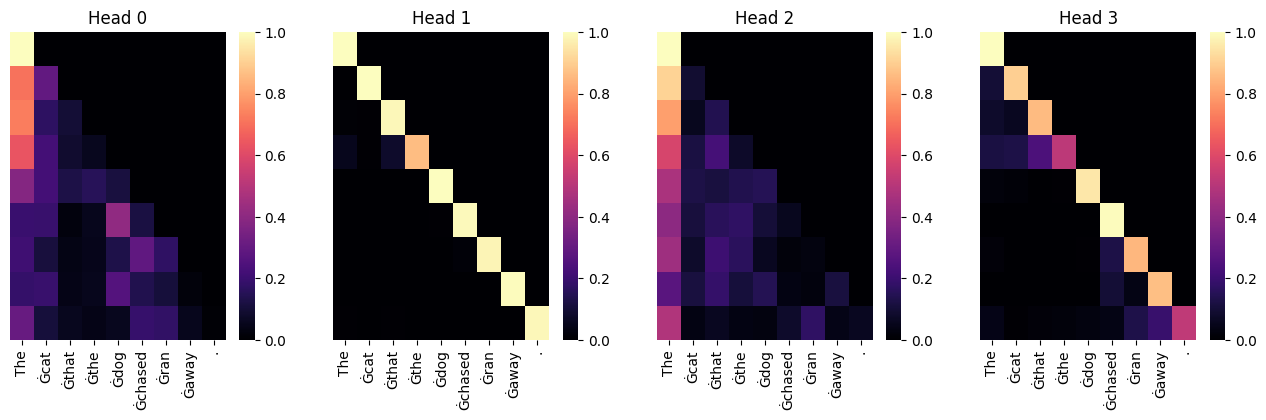

In [107]:
layer = 0
fig, axes = plt.subplots(1, 4, figsize=(16,4))

for head in range(4):
    A = out.attentions[layer][0, head].detach().cpu().numpy()
    sns.heatmap(A, xticklabels=tokens, yticklabels=[],
                cmap="magma", ax=axes[head])
    axes[head].set_title(f"Head {head}")

plt.show()

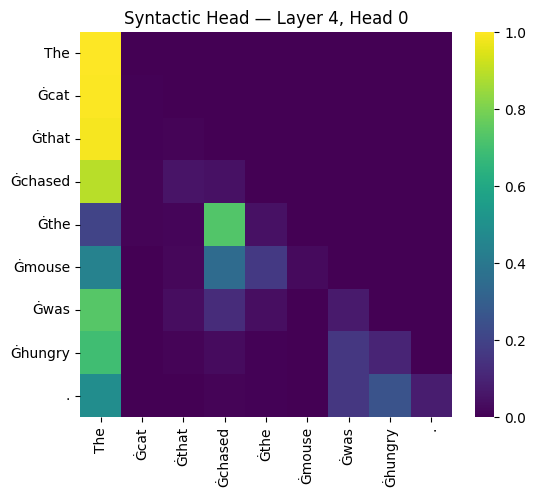

In [120]:
prompt = "The cat that chased the mouse was hungry."
x, out = run(prompt)
tokens = tok.convert_ids_to_tokens(x["input_ids"][0])

layer = 4
head = 0

A = out.attentions[layer][0, head].detach().cpu().numpy()

plt.figure(figsize=(6,5))
sns.heatmap(A, xticklabels=tokens, yticklabels=tokens,
            cmap="viridis")
plt.title(f"Syntactic Head — Layer {layer}, Head {head}")
plt.show()

## Long-range dependencies

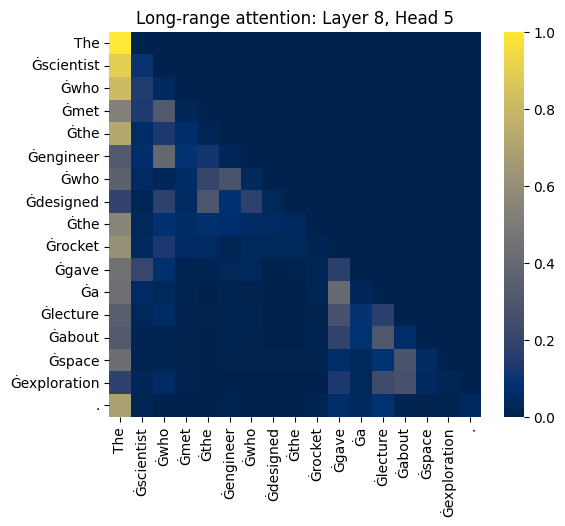

In [124]:
prompt = (
    "The scientist who met the engineer who designed the rocket "
    "gave a lecture about space exploration."
)
x, out = run(prompt)

tokens = tok.convert_ids_to_tokens(x["input_ids"][0])
A = out.attentions[8][0,5].detach().cpu().numpy()  # arbitrary deeper head

plt.figure(figsize=(6,5))
sns.heatmap(A, xticklabels=tokens, yticklabels=tokens,
            cmap="cividis")
plt.title("Long-range attention: Layer 8, Head 5")
plt.show()

## Visualizing the distribution over next tokens

In [128]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

tok = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2").to("cuda").eval()

def show_next_token_distribution(prompt, k=20):
    # Encode
    x = tok(prompt, return_tensors="pt").to("cuda")
    
    with torch.no_grad():
        out = model(**x)
    
    # Logits for final position
    logits = out.logits[0, -1]        # shape: [vocab_size]
    probs  = torch.softmax(logits, 0) # convert to probability dist

    # Top-k
    topk = torch.topk(probs, k)
    ids   = topk.indices.cpu().tolist()
    vals  = topk.values.cpu().tolist()
    words = [tok.decode([i]) for i in ids]

    # Print results
    for w, p in zip(words, vals):
        print(f"{w:12s}  {p:.4f}")
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.bar(range(k), vals)
    plt.xticks(range(k), words, rotation=45, ha="right")
    plt.ylabel("Probability")
    plt.title(f"Top-{k} Next Token Distribution")
    plt.tight_layout()
    plt.show()

 floor        0.0764
 bed          0.0653
 couch        0.0541
 ground       0.0521
 edge         0.0478
 bench        0.0316
 table        0.0315
 sofa         0.0288
 other        0.0199
 back         0.0190
 side         0.0166
 chair        0.0124
 stool        0.0111
 top          0.0108
 grass        0.0097
 seat         0.0087
 wall         0.0082
 desk         0.0075
 cat          0.0070
 front        0.0070


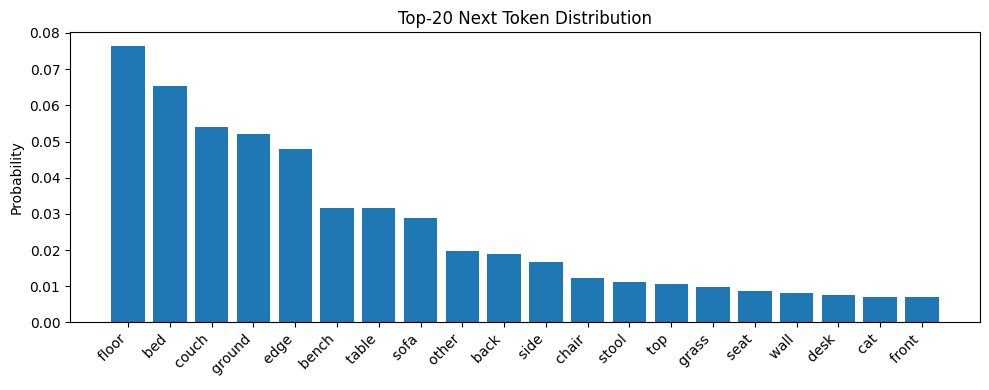

In [129]:
# Example:
show_next_token_distribution("The cat sat on the")